In [1]:
from google.colab import drive
drive.mount('/content/gdrive') #official

dest_train='/content/gdrive/My Drive/Top_Opt_colab_notebooks/corrected_colors/for_training/train_dataset/trainsamples_415-428.npy'
dest_val='/content/gdrive/My Drive/Top_Opt_colab_notebooks/corrected_colors/for_validating/val_dataset/valsamples_413(4)-413(20).npy'
dest_test='/content/gdrive/My Drive/Top_Opt_colab_notebooks/corrected_colors/for_testing/test_dataset/testsamples_413(0)-413(4).npy'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#1. Define color conversions

In [0]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
import matplotlib
from PIL import Image
from torch import nn
import torch
from torchvision import transforms
import numpy as np
import os
import shutil
from torchvision.utils import make_grid

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

###
mapvals=np.load('/content/gdrive/My Drive/Top_Opt_colab_notebooks/corrected_colors/mapvals_rainbow-gray.npy',allow_pickle=True)
#mapvals=list(mapvals)
#mapvals.append(np.array([1.,1.,1.]))
#mapvals=np.array(mapvals)
#shutil.copy('/content/gdrive/My Drive/Top_Opt_colab_notebooks/corrected_colors/mapvals_rainbow-gray.npy','/content/gdrive/My Drive/Top_Opt_colab_notebooks/corrected_colors/mapvals_rainbow-gray2.npy')
#np.save('/content/gdrive/My Drive/Top_Opt_colab_notebooks/corrected_colors/mapvals_rainbow-gray.npy',mapvals)
###

def rainbow2gray(image):
  r = np.linspace(0,1, 256)
  newim = np.zeros((image.shape[0],image.shape[1]),dtype='uint8')
  for i in range(image.shape[0]):
      for j in range(image.shape[1]):
          c = image[i,j,:3]
          c=c.astype('float32')/255.0
          gray=r[np.argmin(np.sum((mapvals - c)**2, axis=1))]
          newim[i,j] =  np.round(255.0*gray).astype('uint8')
  return newim

def gray2rainbow(gray):
  rainbow=np.zeros((gray.shape[0],gray.shape[1],3),'float32')
  for i in range(gray.shape[0]):
    for j in range(gray.shape[1]):
      rainbow[i,j,:]=mapvals[gray[i,j]]
  return (255*rainbow).astype('uint8')  


def gray2rainbow_batch(ims): #(batch_size,1,64,64)
  rainbow=[]
  for i in range(ims.shape[0]):
    rainbow.append(gray2rainbow(ims[i][0]))
  return np.array(rainbow) 

In [3]:
print(mapvals.shape)

(256, 3)


#2. Define Dataset

In [4]:


class TopOpt(torch.utils.data.Dataset):
  def __init__(self,transform=None,type_='train',train_potion=0.8):
    self.transform=transform
    if type_=='train':
      self.dataset=np.load(dest_train,allow_pickle=True)
    if type_=='test':
      self.dataset=np.load(dest_test,allow_pickle=True)
    if type_=='val':
      self.dataset=np.load(dest_val,allow_pickle=True)

  def __len__(self):
    return len(self.dataset)
  def __getitem__(self,idx):
    img=Image.fromarray(self.dataset[idx][0])
    label=self.dataset[idx][1]
    if self.transform!=None:
      img=self.transform(img)
    return (label,img)


img_size=64
transform=transforms.Compose([transforms.Resize((img_size,img_size)),transforms.ToTensor()]) #,transforms.Normalize((0.5,),(0.5,))

dataset_train=TopOpt(transform=transform,type_='train')
dataset_test=TopOpt(transform=transform,type_='test')
dataset_val=TopOpt(transform=transform,type_='val')

batch_size=64
dataloader_train=torch.utils.data.DataLoader(dataset_train,batch_size=batch_size,shuffle=False,drop_last=True)
dataloader_test=torch.utils.data.DataLoader(dataset_test,batch_size=5,shuffle=False,drop_last=True)
dataloader_val=torch.utils.data.DataLoader(dataset_val,batch_size=15,shuffle=False,drop_last=True)


print("train :",len(dataset_train),'test :',len(dataset_test),'val :',len(dataset_val))

train : 624 test : 5 val : 15


torch.Size([64, 2]) torch.Size([64, 1, 64, 64])


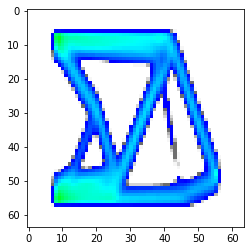

In [5]:
for (x,y) in dataloader_train:
  print(x.shape,y.shape)
  plt.imshow(gray2rainbow((255*y[0,0,:,:]).numpy().astype('uint8')))
  break

#3. Define Model

In [6]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.linear=nn.Linear(2,100)
    self.cnn=nn.Sequential(
        nn.ConvTranspose2d(100,64,kernel_size=4,stride=2,padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(64),
        nn.Dropout(0.2),

        nn.ConvTranspose2d(64,32,kernel_size=4,stride=2,padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(32),
        nn.Dropout(0.2),

        nn.ConvTranspose2d(32,16,kernel_size=4,stride=2,padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(16),
        nn.Dropout(0.2),
    
        nn.ConvTranspose2d(16,8,kernel_size=4,stride=2,padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(8),
        nn.Dropout(0.2),

        nn.ConvTranspose2d(8,4,kernel_size=4,stride=2,padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(4),
        nn.Dropout(0.2),

        nn.ConvTranspose2d(4,1,kernel_size=4,stride=2,padding=1),
    )

  def forward(self,x):
    x=x.float()
    x=x.view(-1,2)
    x=self.linear(x)
    x=x.view(-1,100,1,1)
    y=self.cnn(x)
    return y
cnn1=CNN().to(device)
criterion=nn.L1Loss().to(device)
opt=torch.optim.Adam(cnn1.parameters(),lr=0.0002)

from torchsummary import summary
summary(cnn1,input_size=(1,2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]             300
   ConvTranspose2d-2             [-1, 64, 2, 2]         102,464
         LeakyReLU-3             [-1, 64, 2, 2]               0
       BatchNorm2d-4             [-1, 64, 2, 2]             128
           Dropout-5             [-1, 64, 2, 2]               0
   ConvTranspose2d-6             [-1, 32, 4, 4]          32,800
         LeakyReLU-7             [-1, 32, 4, 4]               0
       BatchNorm2d-8             [-1, 32, 4, 4]              64
           Dropout-9             [-1, 32, 4, 4]               0
  ConvTranspose2d-10             [-1, 16, 8, 8]           8,208
        LeakyReLU-11             [-1, 16, 8, 8]               0
      BatchNorm2d-12             [-1, 16, 8, 8]              32
          Dropout-13             [-1, 16, 8, 8]               0
  ConvTranspose2d-14            [-1, 8,

#4. Load weights

In [0]:
save_path='/content/gdrive/My Drive/Top_Opt_colab_notebooks/corrected_colors/for_training/model_1_CNN'
#os.mkdir(save_path)


def load_checkpoint(losses_train,losses_val,cnn1,start):
  cnn1.load_state_dict(torch.load(save_path+'/weights.pth'))
  losses_train+=list(np.load(save_path+'/loss_train.npy',allow_pickle=True))
  losses_val+=list(np.load(save_path+'/loss_val.npy',allow_pickle=True))
  start+=np.load(save_path+'/epochs.npy',allow_pickle=True)[0]+1
  return start 

#5. Training - **training is commented -> check and uncomment** -

In [9]:
cnn1=CNN().to(device)
criterion=nn.L1Loss().to(device)
opt=torch.optim.Adam(cnn1.parameters(),lr=0.0001)

start=0
losses_train=[]
losses_val=[]

#start=load_checkpoint(losses_train,losses_val,cnn1,start)

cnn1.train()

for epoch in range(start,2000):
  for i,(x,y) in enumerate(dataloader_train):
    x,y=x.to(device),y.to(device)
    opt.zero_grad()
    pred=cnn1(x)

    loss=criterion(pred.view(x.shape[0],-1),y.view(x.shape[0],-1))
    loss.backward()
    opt.step()


    # results for test set
    with torch.no_grad():
      x_val,y_val=next(iter(dataloader_val))
      x_val,y_val=x_val.to(device),y_val.to(device)
      loss_val=criterion(cnn1(x_val).detach().view(x_val.shape[0],-1),y_val.view(x_val.shape[0],-1))

  losses_train.append(loss.item())
  losses_val.append(loss_val.item())


  if epoch%50==0:
    plt.figure()
    plt.plot(losses_train, label="train_loss")
    plt.plot(losses_val, label="val_loss")
    plt.legend()
    plt.title(f'epoch: {epoch},i: {i}')
    plt.show()

    with torch.no_grad():
      print("pred,y:",pred[0][0][0][0],y[0][0][0][0])
      y_pred_train=gray2rainbow_batch((np.clip(255*cnn1(x[:5]).cpu().detach().numpy(),0,255)).astype('uint8')).astype('float32')/255.0
      y_train=gray2rainbow_batch((np.clip(255*y[:5].cpu().detach().numpy(),0,255)).astype('uint8')).astype('float32')/255.0
      y_pred_val=gray2rainbow_batch((np.clip(255*cnn1(x_val).cpu().detach().numpy(),0,255)).astype('uint8')).astype('float32')/255.0
      y_val=gray2rainbow_batch((np.clip(255*y_val.cpu().detach().numpy(),0,255)).astype('uint8')).astype('float32')/255.0


      plt.figure()      
      imgs=torch.cat([torch.Tensor(y_pred_train),torch.Tensor(y_train)],0).permute(0,3,1,2).data.cpu()
      grid=make_grid(imgs,nrow=5).permute(1,2,0).numpy()
      plt.imshow(grid)
      plt.title('generated -> for train data')
      plt.show()

      plt.figure()
      imgs=torch.cat([torch.Tensor(y_pred_val),torch.Tensor(y_val)],0).permute(0,3,1,2).data.cpu()
      grid=make_grid(imgs,nrow=5).permute(1,2,0).numpy()
      plt.imshow(grid)
      plt.title('generated -> for val data')
      plt.show()

      torch.save(cnn1.state_dict(), save_path+'/weights.pth')
      np.save(save_path+'/loss_train.npy',losses_train)
      np.save(save_path+'/loss_val.npy',losses_val)
      np.save(save_path+'/epochs.npy',np.array([epoch]))

Output hidden; open in https://colab.research.google.com to view.

#6. Evaluate

In [0]:
cnn1=CNN().to(device)
cnn1.load_state_dict(torch.load(save_path+'/weights.pth',map_location=torch.device('cpu')))

cnn1.eval()
with torch.no_grad():
  for x_test,y_test in dataloader_test:
    y_pred_test=gray2rainbow_batch((np.clip(255*cnn1(x_test).cpu().detach().numpy(),0,255)).astype('uint8')).astype('float32')/255.0
    y_test=gray2rainbow_batch((np.clip(255*y_test.cpu().detach().numpy(),0,255)).astype('uint8')).astype('float32')/255.0


    plt.figure()      
    imgs=torch.cat([torch.Tensor(y_pred_test),torch.Tensor(y_test)],0).permute(0,3,1,2).data.cpu()
    grid=make_grid(imgs,nrow=5).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.title('generated -> for test data')
    plt.show()


RuntimeError: ignored